In [1]:
pip install pandas numpy scikit-learn matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 1 — Import libraries for file handling, text cleaning, data manipulation, and machine-learning models

In [2]:
import os
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Step 2 — Define and validate file paths to the Amazon Reviews training and testing datasets

In [4]:
from pathlib import Path

BASE_DIR = Path("/Users/aryanmore/Aryan /project/sentimental analysis/Amazon Reviews Archive")

TRAIN_PATH = BASE_DIR / "train.csv"
TEST_PATH  = BASE_DIR / "test.csv"

print("Base dir exists:", BASE_DIR.exists())
print("Train exists:", TRAIN_PATH.exists())
print("Test exists:", TEST_PATH.exists())

Base dir exists: True
Train exists: True
Test exists: True


### Step 3 — Load a small sample of the dataset to verify structure and prevent memory issues

In [5]:
train_df = pd.read_csv(TRAIN_PATH, header=None, names=["polarity", "title", "text"], nrows=20)
test_df  = pd.read_csv(TEST_PATH,  header=None, names=["polarity", "title", "text"], nrows=20)

print("Train sample shape:", train_df.shape)
print("Test sample shape:", test_df.shape)

train_df.head(5)

Train sample shape: (20, 3)
Test sample shape: (20, 3)


,polarity,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


### Step 4 — Prepare the data by filtering valid labels, converting sentiment values, and combining review title and text

In [6]:
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # keep only valid labels
    df = df[df["polarity"].isin([1, 2])]

    # convert labels: 1 -> 0 (negative), 2 -> 1 (positive)
    df["label"] = df["polarity"].map({1: 0, 2: 1})

    # fill missing values
    df["title"] = df["title"].fillna("")
    df["text"] = df["text"].fillna("")

    # combine title + text
    df["full_text"] = (df["title"].astype(str) + " " + df["text"].astype(str)).str.strip()

    # remove empty rows
    df = df[df["full_text"].str.len() > 0]

    return df[["label", "full_text"]]

train_prepped = prepare_dataframe(train_df)
test_prepped  = prepare_dataframe(test_df)

print("Train prepped shape:", train_prepped.shape)
print("Test prepped shape:", test_prepped.shape)

print("Train label distribution:")
print(train_prepped["label"].value_counts())

train_prepped.head(5)

Train prepped shape: (20, 2)
Test prepped shape: (20, 2)
Train label distribution:
label
1    14
0     6
Name: count, dtype: int64


,label,full_text
0,1,Stuning even for the non-gamer This sound trac...
1,1,The best soundtrack ever to anything. I'm read...
2,1,Amazing! This soundtrack is my favorite music ...
3,1,Excellent Soundtrack I truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


### Step 5 — Clean review text by lowercasing, removing noise, and normalising whitespace

In [7]:
def basic_clean(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"\s+", " ", text)            # normalize whitespace
    text = re.sub(r"[^a-z0-9\s']", " ", text)   # keep letters/numbers/apostrophes
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_prepped["clean_text"] = train_prepped["full_text"].apply(basic_clean)
test_prepped["clean_text"]  = test_prepped["full_text"].apply(basic_clean)

train_prepped[["label", "clean_text"]].head(5)

,label,clean_text
0,1,stuning even for the non gamer this sound trac...
1,1,the best soundtrack ever to anything i'm readi...
2,1,amazing this soundtrack is my favorite music o...
3,1,excellent soundtrack i truly like this soundtr...
4,1,remember pull your jaw off the floor after hea...


### Step 6 — Convert cleaned text into numerical features using TF-IDF vectorisation

In [8]:
vectorizer = TfidfVectorizer(
    max_features=20_000,   # small for now (safe for debugging)
    ngram_range=(1, 2),    # single words + two-word phrases
    min_df=1
)

X_train = vectorizer.fit_transform(train_prepped["clean_text"])
y_train = train_prepped["label"].values

X_test = vectorizer.transform(test_prepped["clean_text"])
y_test = test_prepped["label"].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Example vocab size:", len(vectorizer.vocabulary_))

X_train shape: (20, 2196)
X_test shape: (20, 2196)
Example vocab size: 2196


### Step 7 — Train a Logistic Regression classifier to predict positive vs negative sentiment

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=4))

Accuracy: 0.55
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.5500    1.0000    0.7097        11

    accuracy                         0.5500        20
   macro avg     0.2750    0.5000    0.3548        20
weighted avg     0.3025    0.5500    0.3903        20



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

### Step 8 — Evaluate model performance using accuracy and precision-recall-based metrics

In [10]:
def load_sample_csv(path, n_rows=10_000, chunksize=2_000):
    collected = []
    total = 0

    for chunk in pd.read_csv(
        path,
        header=None,
        names=["polarity", "title", "text"],
        chunksize=chunksize,
        encoding="utf-8",
        on_bad_lines="skip"
    ):
        collected.append(chunk)
        total += len(chunk)
        if total >= n_rows:
            break

    return pd.concat(collected, ignore_index=True).head(n_rows)

train_df = load_sample_csv(TRAIN_PATH, n_rows=10_000)
test_df  = load_sample_csv(TEST_PATH,  n_rows=2_000)

print(train_df.shape, test_df.shape)

(10000, 3) (2000, 3)


### Step 9 — Scale the pipeline by loading a larger sample of reviews using chunked processing

In [11]:
train_prepped = prepare_dataframe(train_df)
test_prepped  = prepare_dataframe(test_df)

train_prepped["clean_text"] = train_prepped["full_text"].apply(basic_clean)
test_prepped["clean_text"]  = test_prepped["full_text"].apply(basic_clean)

print("Train:", train_prepped.shape, " Test:", test_prepped.shape)
print("Train label balance:\n", train_prepped["label"].value_counts(normalize=True))
print("Test label balance:\n", test_prepped["label"].value_counts(normalize=True))

Train: (10000, 3)  Test: (2000, 3)
Train label balance:
 label
0    0.5097
1    0.4903
Name: proportion, dtype: float64
Test label balance:
 label
1    0.523
0    0.477
Name: proportion, dtype: float64


### Step 10 — Re-train the sentiment model on the larger dataset for more reliable performance

In [12]:
vectorizer = TfidfVectorizer(
    max_features=50_000,   # reasonable for 10k rows
    ngram_range=(1, 2),
    min_df=2
)

X_train = vectorizer.fit_transform(train_prepped["clean_text"])
y_train = train_prepped["label"].values

X_test = vectorizer.transform(test_prepped["clean_text"])
y_test = test_prepped["label"].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Vocabulary size:", len(vectorizer.vocabulary_))

X_train shape: (10000, 50000)
X_test shape: (2000, 50000)
Vocabulary size: 50000


### Step 11 — Analyse model behaviour by examining prediction results on unseen test data

In [13]:
model = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, digits=4))

Accuracy: 0.8735
              precision    recall  f1-score   support

           0     0.8640    0.8721    0.8680       954
           1     0.8824    0.8748    0.8785      1046

    accuracy                         0.8735      2000
   macro avg     0.8732    0.8734    0.8733      2000
weighted avg     0.8736    0.8735    0.8735      2000



### Graph 1 — Model confidence distribution (histogram of predicted probability for positive sentiment; peaks away from 0.5 indicate clearer separation)

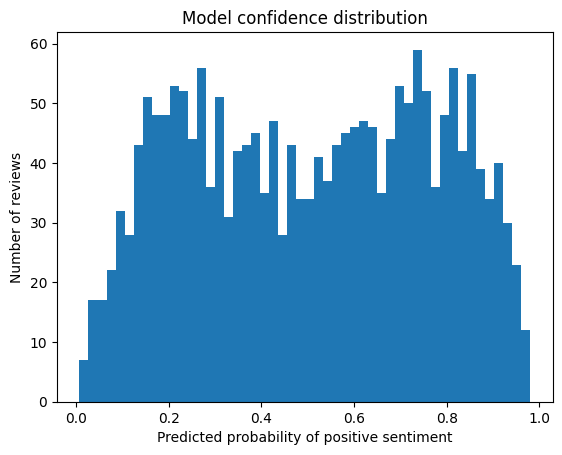

In [20]:
probs = model.predict_proba(X_test)

plt.figure()
plt.hist(probs[:, 1], bins=50)
plt.xlabel("Predicted probability of positive sentiment")
plt.ylabel("Number of reviews")
plt.title("Model confidence distribution")
plt.savefig("model_confidence_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

### Graph 2- Review length distribution by sentiment (shows whether negative and positive reviews differ in how much detail customers write)

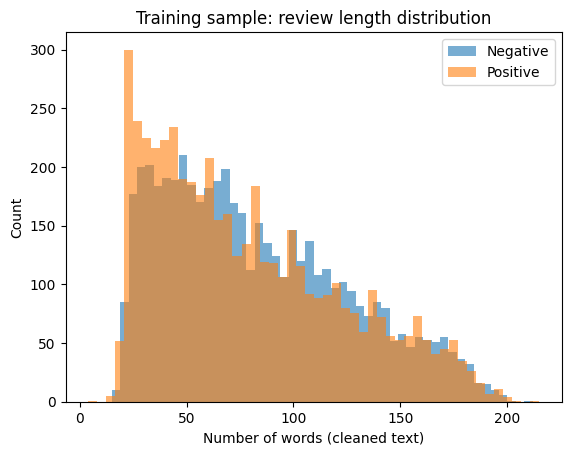

In [19]:
train_prepped["text_len"] = train_prepped["clean_text"].str.split().apply(len)

neg = train_prepped.loc[train_prepped["label"] == 0, "text_len"]
pos = train_prepped.loc[train_prepped["label"] == 1, "text_len"]

plt.figure()
plt.hist(neg, bins=50, alpha=0.6, label="Negative")
plt.hist(pos, bins=50, alpha=0.6, label="Positive")
plt.title("Training sample: review length distribution")
plt.xlabel("Number of words (cleaned text)")
plt.ylabel("Count")
plt.legend()
plt.savefig("review_length_by_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

### Graph 3- Most influential words and phrases driving negative vs positive sentiment predictions (based on Logistic Regression feature coefficients)

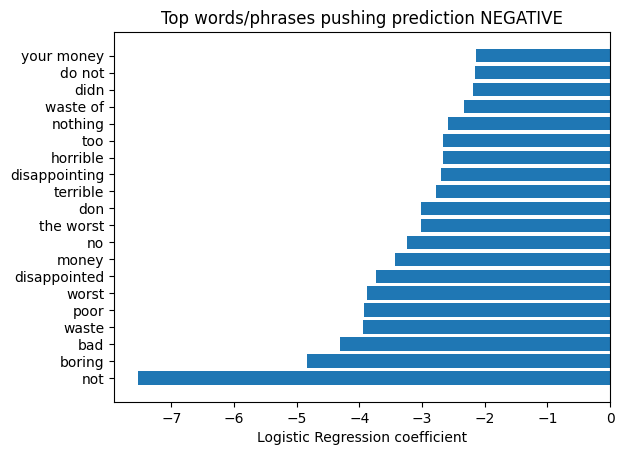

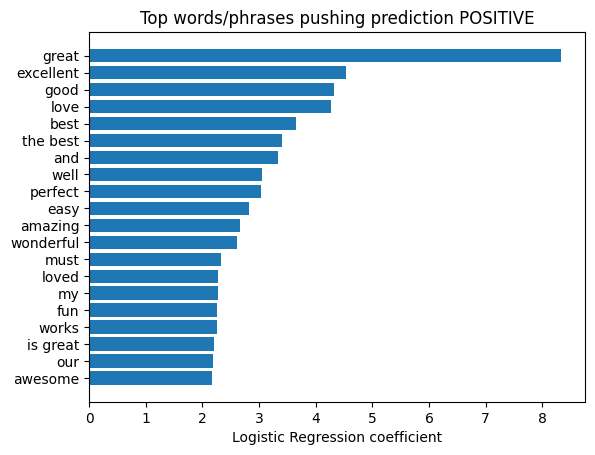

In [23]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())
coefs = model.coef_[0]  # one row for binary classification

top_n = 20
top_pos_idx = np.argsort(coefs)[-top_n:]
top_neg_idx = np.argsort(coefs)[:top_n]

top_pos_words = feature_names[top_pos_idx]
top_neg_words = feature_names[top_neg_idx]

top_pos_vals = coefs[top_pos_idx]
top_neg_vals = coefs[top_neg_idx]

# Plot negative
plt.figure()
plt.barh(top_neg_words, top_neg_vals)
plt.title("Top words/phrases pushing prediction NEGATIVE")
plt.xlabel("Logistic Regression coefficient")
plt.savefig("top_negative_words.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot positive
plt.figure()
plt.barh(top_pos_words, top_pos_vals)
plt.title("Top words/phrases pushing prediction POSITIVE")
plt.xlabel("Logistic Regression coefficient")
plt.savefig("top_positive_words.png", dpi=300, bbox_inches="tight")
plt.show()